In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torchaudio
from torch.utils.data import Dataset
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import librosa
from birdsong_dataset import AudioDataset


In [45]:
df = pd.read_csv("./data/birdsong_metadata.csv")
df.nunique()

file_id                   264
genus                      66
species                    85
english_cname              88
who_provided_recording     68
country                    18
latitude                  195
longitute                 198
type                       54
license                     4
dtype: int64

In [6]:
import torch
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, name , species = sample[0], sample[1],sample[2]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image) , torch.from_numpy(name) , torch.from_numpy(species)

In [7]:
dataset = AudioDataset(transform = ToTensor())

Loading The Data...
Data Loaded !


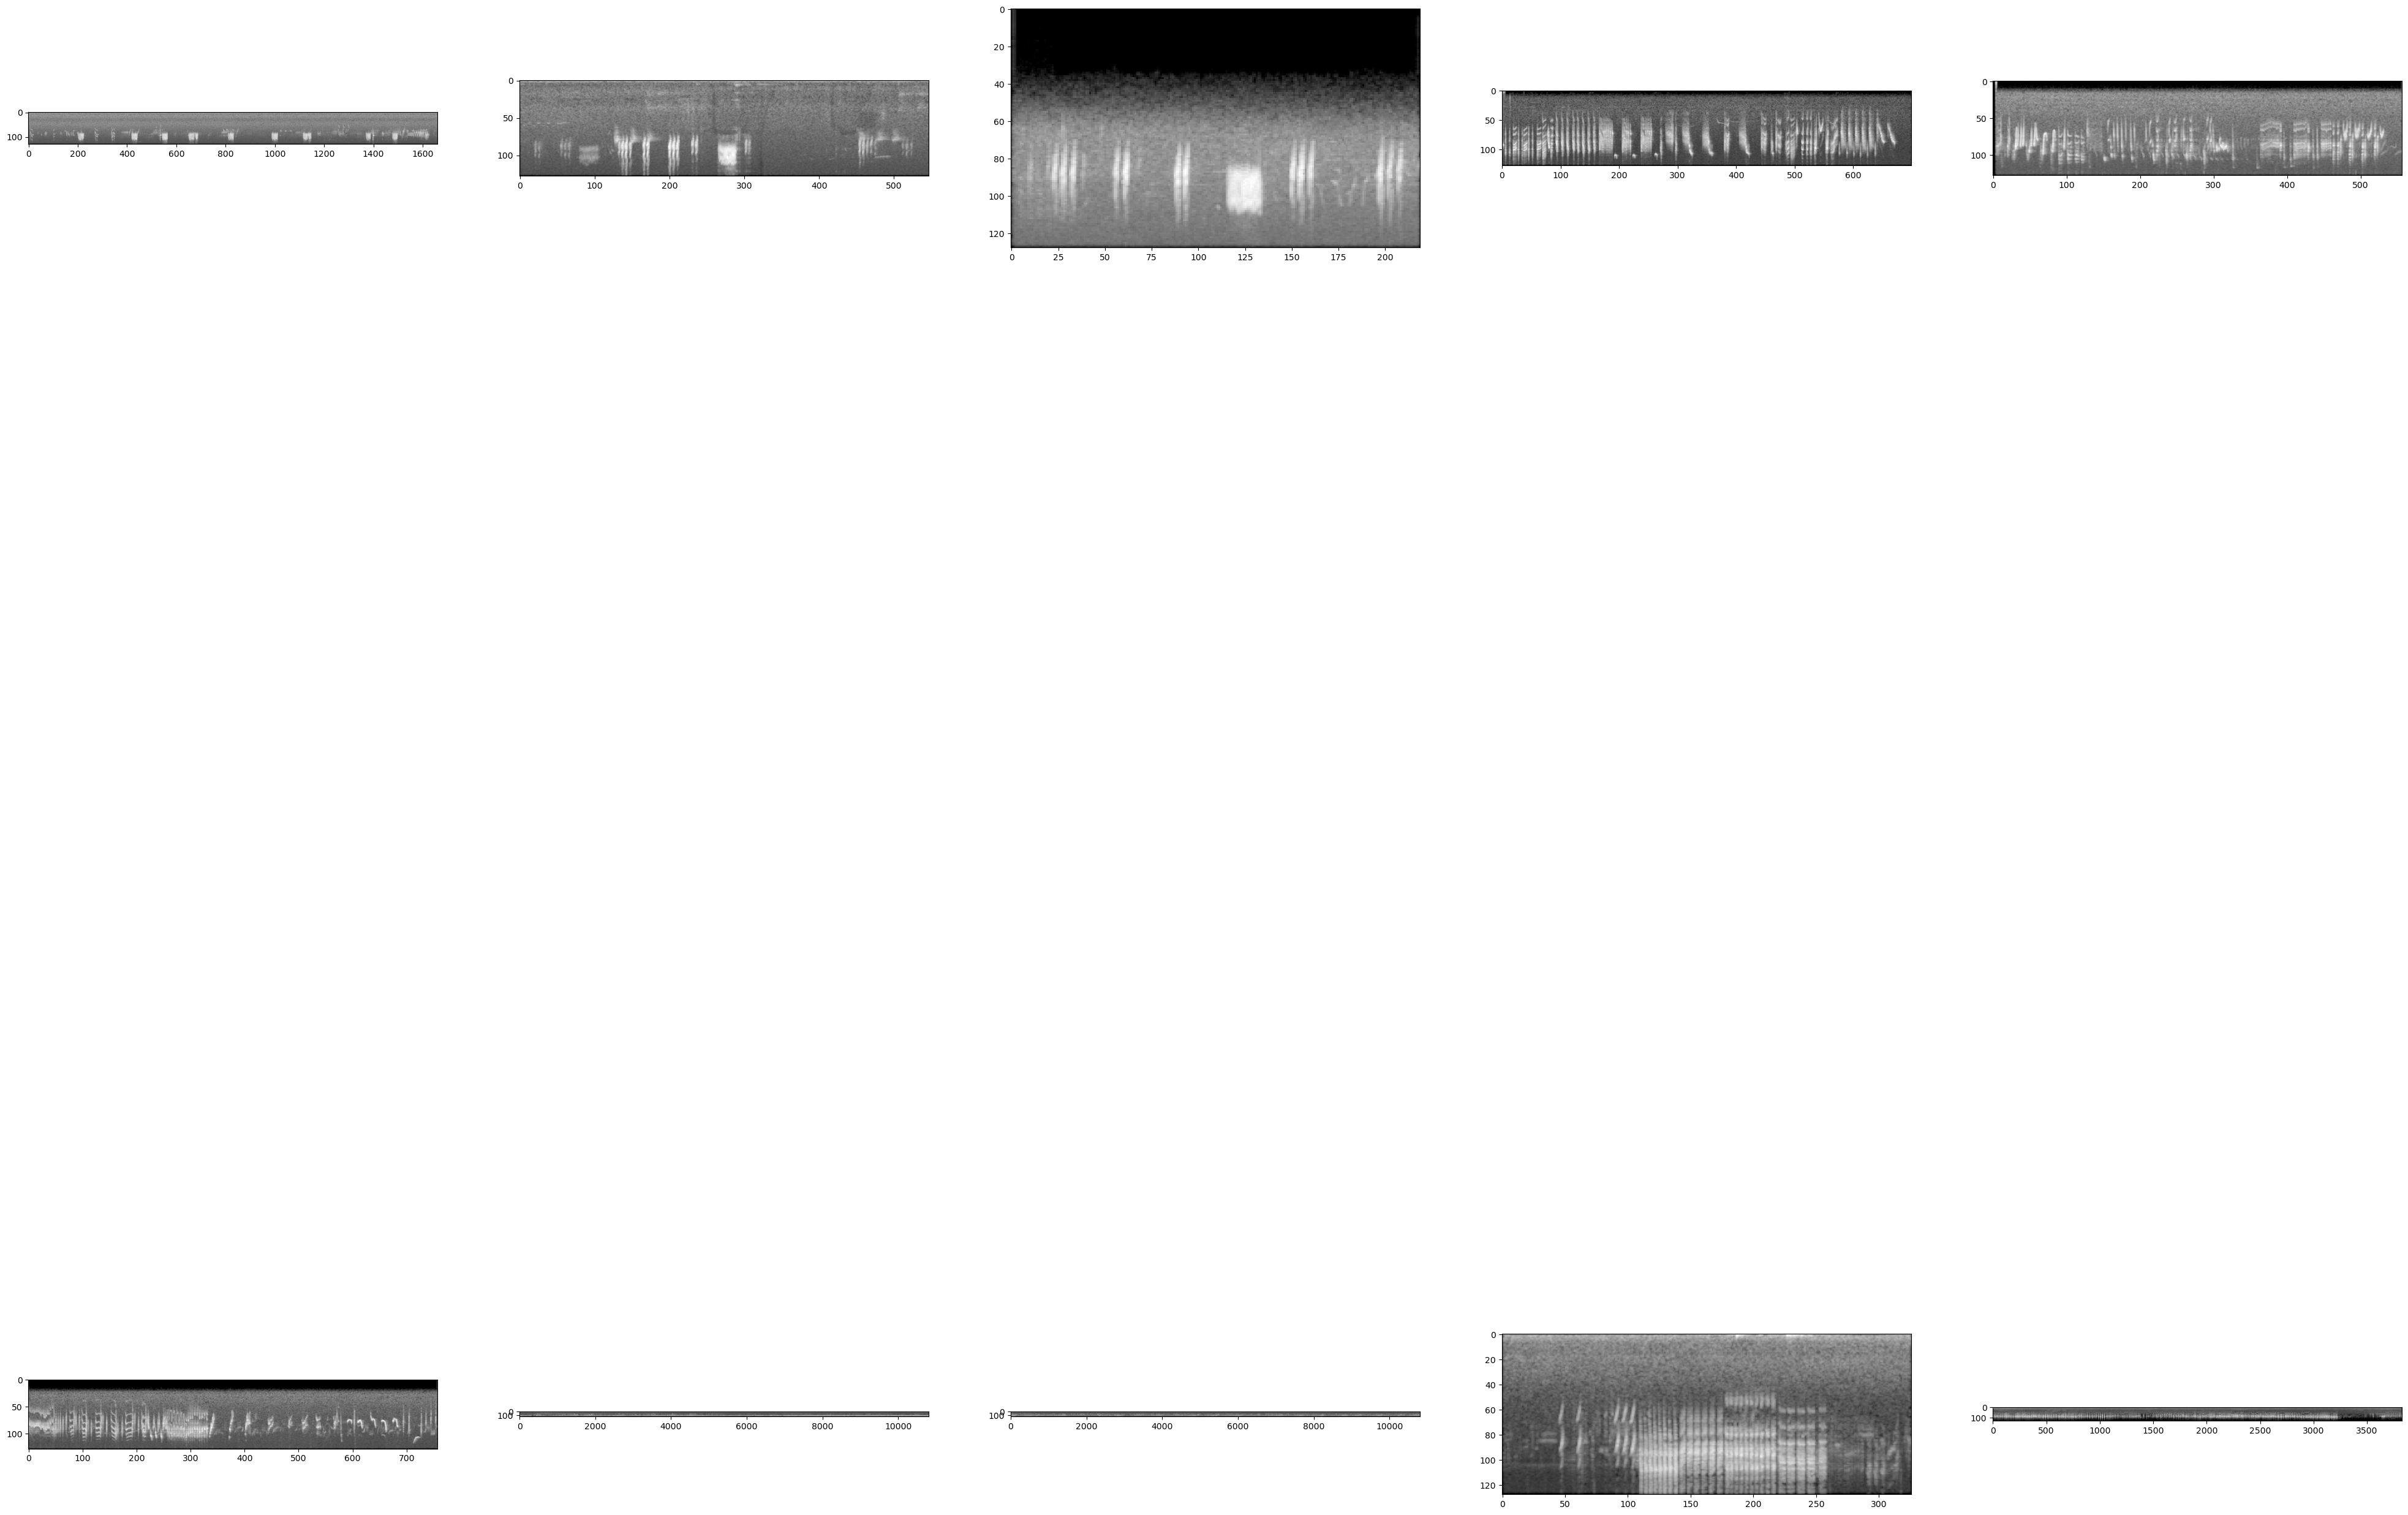

In [151]:
from matplotlib import pyplot as plt
plt.figure(figsize=(50,50))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(dataset[i][0].to('cpu').numpy().transpose((1,2,0)), cmap='gray')

In [135]:
from torch.utils.data import random_split, DataLoader

# Assuming you have your dataset object named 'dataset' and the total size of the dataset is 'len(dataset)'
# Define the sizes of your desired splits
train_size = int(0.6 * len(dataset))  # 80% of the data for training
val_size = int(0.25 * len(dataset))    # 10% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split to create the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 1
# You can then create data loaders for each split if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [136]:
len(train_loader) , len(val_loader) , len(test_loader)

for (audio , name , species) in train_loader:
    print(audio.shape)

torch.Size([1, 1, 128, 1728])
torch.Size([1, 1, 128, 2891])
torch.Size([1, 1, 128, 3612])
torch.Size([1, 1, 128, 549])
torch.Size([1, 1, 128, 682])
torch.Size([1, 1, 128, 4163])
torch.Size([1, 1, 128, 961])
torch.Size([1, 1, 128, 1150])
torch.Size([1, 1, 128, 3648])
torch.Size([1, 1, 128, 7616])
torch.Size([1, 1, 128, 3021])
torch.Size([1, 1, 128, 547])
torch.Size([1, 1, 128, 3517])
torch.Size([1, 1, 128, 3167])
torch.Size([1, 1, 128, 2254])
torch.Size([1, 1, 128, 4279])
torch.Size([1, 1, 128, 1959])
torch.Size([1, 1, 128, 1511])
torch.Size([1, 1, 128, 2260])
torch.Size([1, 1, 128, 2120])
torch.Size([1, 1, 128, 1340])
torch.Size([1, 1, 128, 1808])
torch.Size([1, 1, 128, 1941])
torch.Size([1, 1, 128, 3066])
torch.Size([1, 1, 128, 7937])
torch.Size([1, 1, 128, 1986])
torch.Size([1, 1, 128, 6657])
torch.Size([1, 1, 128, 1471])
torch.Size([1, 1, 128, 3449])
torch.Size([1, 1, 128, 7729])
torch.Size([1, 1, 128, 8980])
torch.Size([1, 1, 128, 1541])
torch.Size([1, 1, 128, 1192])
torch.Size([1,

In [112]:
from torch import nn
import torch


class BirdSongClassifier(nn.Module):
    def __init__(self, num_classes_1 = 85 , num_classes_2 = 88):
        super(BirdSongClassifier,self).__init__()
        # backbone
        self.conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,3))
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,3))
        self.conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((3,3))

        # multilabel classification for classes 
        
        self.names_l1 = nn.Linear(64*3*73 , 512 )
        self.names_relu1 = nn.ReLU()
        self.names_l2 = nn.Linear(512 , num_classes_1 )
        
        # multilabel classification for species       
        
        self.species_l1 = nn.Linear(64*3*73 , 512 )
        self.species_relu1 = nn.ReLU()
        self.species_l2 = nn.Linear(512 , num_classes_2 )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        backbone = self.pool3(x)
        print(backbone.size())
        #forward for names
        x1 = backbone.view(-1, backbone.size(0) * backbone.size(1) * backbone.size(2))
        x1 = self.names_l1(x1)
        x1 = self.names_relu1(x1)
        x1 = self.names_l2(x1)
        print(x1.shape)
        #forward for species
        x2 = backbone.view(-1, backbone.size(0) * backbone.size(1) * backbone.size(2))
        x2 = self.species_l1(x2)
        x2 = self.species_relu1(x2)
        x2 = self.species_l2(x2)
        
        print(x2.shape)
        return x1 , x2 

model = BirdSongClassifier()
# print(type(train_dataset[0][0]) , train_dataset[0][0].shape)
pred = model(train_dataset[0][0])
# print(pred)
        
        

torch.Size([64, 3, 75])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x14400 and 14016x512)

In [113]:
torch.argmax(pred[0][0])

tensor(6)

In [114]:
# x = dataset[0][0]
# print(x.shape)
# conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)(x)
# relu1 = nn.ReLU()(conv1)
# pool1 = nn.MaxPool2d((3,3))(relu1)
# conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)(pool1)
# relu2 = nn.ReLU()(conv2)
# pool2 = nn.MaxPool2d((3,3))(relu2)
# conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)(pool2)
# relu3 = nn.ReLU()(conv3)
# pool3 = nn.MaxPool2d((3,3))(relu3)
# print(pool3.shape)



In [ ]:
# sgram = librosa.stft(ds[1][0]
# # librosa.display.specshow(sgram)
# sgram_mag, _ = librosa.magphase(sgram)
# mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=ds[0][1])
# # librosa.display.specshow(mel_scale_sgram)
# mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
# # librosa.display.specshow(mel_sgram, sr=ds[0][1], x_axis='time', y_axis='mel',hop_length=512)